<a href="https://colab.research.google.com/github/namumali/CreditCardFraudDetection/blob/main/CreditCardFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Setup - installs

In [ ]:
!pip install -q imbalanced-learn xgboost
!pip install kagglehub[pandas-datasets]

2) Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Try/except for XGBoost since it may not be installed by default
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

# For handling imbalance
from imblearn.over_sampling import SMOTE

3) Load data & quick checks

In [ ]:
# Adjust path if needed
# DATA_PATH = '/kaggle/input/creditcardfraud/creditcard.csv'
# data = pd.read_csv(DATA_PATH)

import kagglehub
import os

# Download the dataset from KaggleHub
dataset_url = "mlg-ulb/creditcardfraud"
dataset_path = kagglehub.dataset_download(dataset_url)

# List files in the downloaded directory to verify the path and filename
print("Files in downloaded dataset directory:")
for root, dirs, files in os.walk(dataset_path):
    for name in files:
        print(os.path.join(root, name))

# Construct the full path to the CSV file within the downloaded dataset
# Assuming the file is directly in the downloaded path based on typical dataset structures
file_path = os.path.join(dataset_path, 'creditcard.csv')

# Load the dataset from the downloaded path
data = pd.read_csv(file_path)


print('Shape:', data.shape)
print('\nColumns:', data.columns.tolist())

# Quick peek
display(data.head())

# Basic info
print('\nInfo:')
print(data.info())

print('\nMissing values per column:')
print(data.isnull().sum().sort_values(ascending=False).head())

100%|██████████| 66.0M/66.0M [00:00<00:00, 114MB/s] 

Extracting files...


Files in downloaded dataset directory:
/root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv
Shape: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21

Target distribution (class imbalance)

Class
0    284315
1       492
Name: count, dtype: int64

Proportions:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


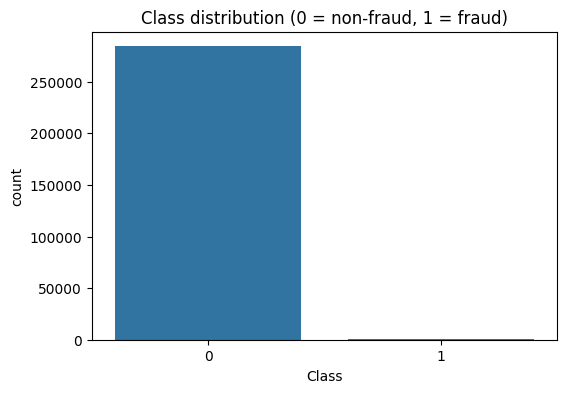

In [ ]:
print(data['Class'].value_counts())
print('\nProportions:')
print(data['Class'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title('Class distribution (0 = non-fraud, 1 = fraud)')
plt.show()

4) Exploratory Data Analysis (EDA)

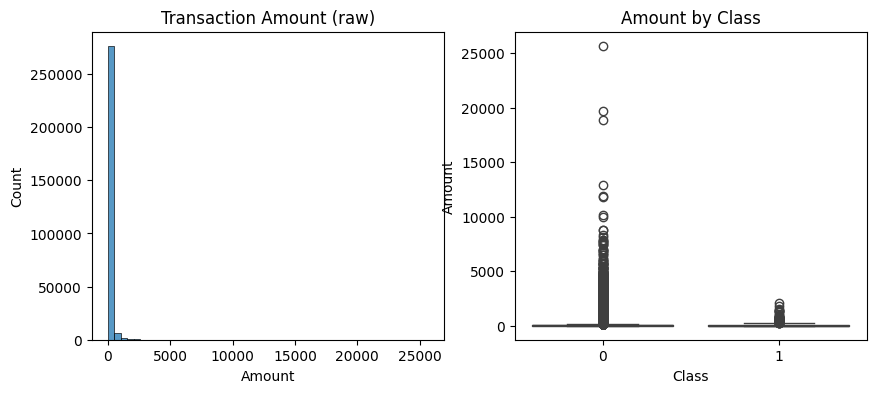

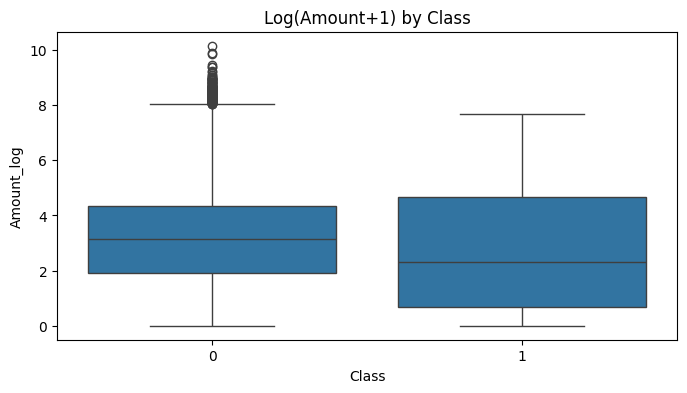

In [ ]:
# Amount distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data['Amount'], bins=50, kde=False)
plt.title('Transaction Amount (raw)')

plt.subplot(1,2,2)
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Amount by Class')
plt.show()

# Log-transformed Amount (optional, helps models)
data['Amount_log'] = np.log1p(data['Amount'])
plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='Amount_log', data=data)
plt.title('Log(Amount+1) by Class')
plt.show()

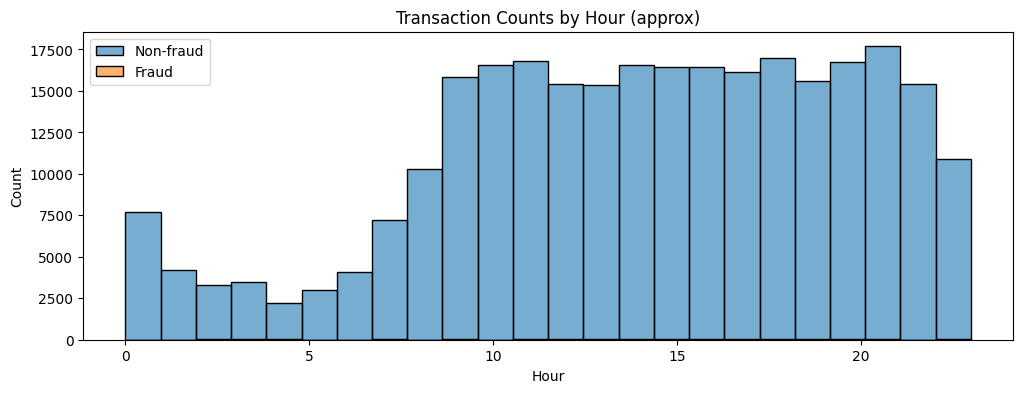

In [ ]:
# Time: convert seconds to hours-of-day roughly (if you want to look for time-of-day patterns).
# Note: 'Time' is seconds elapsed between each transaction and the first transaction in the dataset.
# We will look at simple distribution splits.

data['Hour'] = (data['Time'] // 3600) % 24
plt.figure(figsize=(12,4))
sns.histplot(data[data['Class']==0]['Hour'], label='Non-fraud', stat='count', bins=24, alpha=0.6)
sns.histplot(data[data['Class']==1]['Hour'], label='Fraud', stat='count', bins=24, alpha=0.6)
plt.legend()
plt.title('Transaction Counts by Hour (approx)')
plt.show()

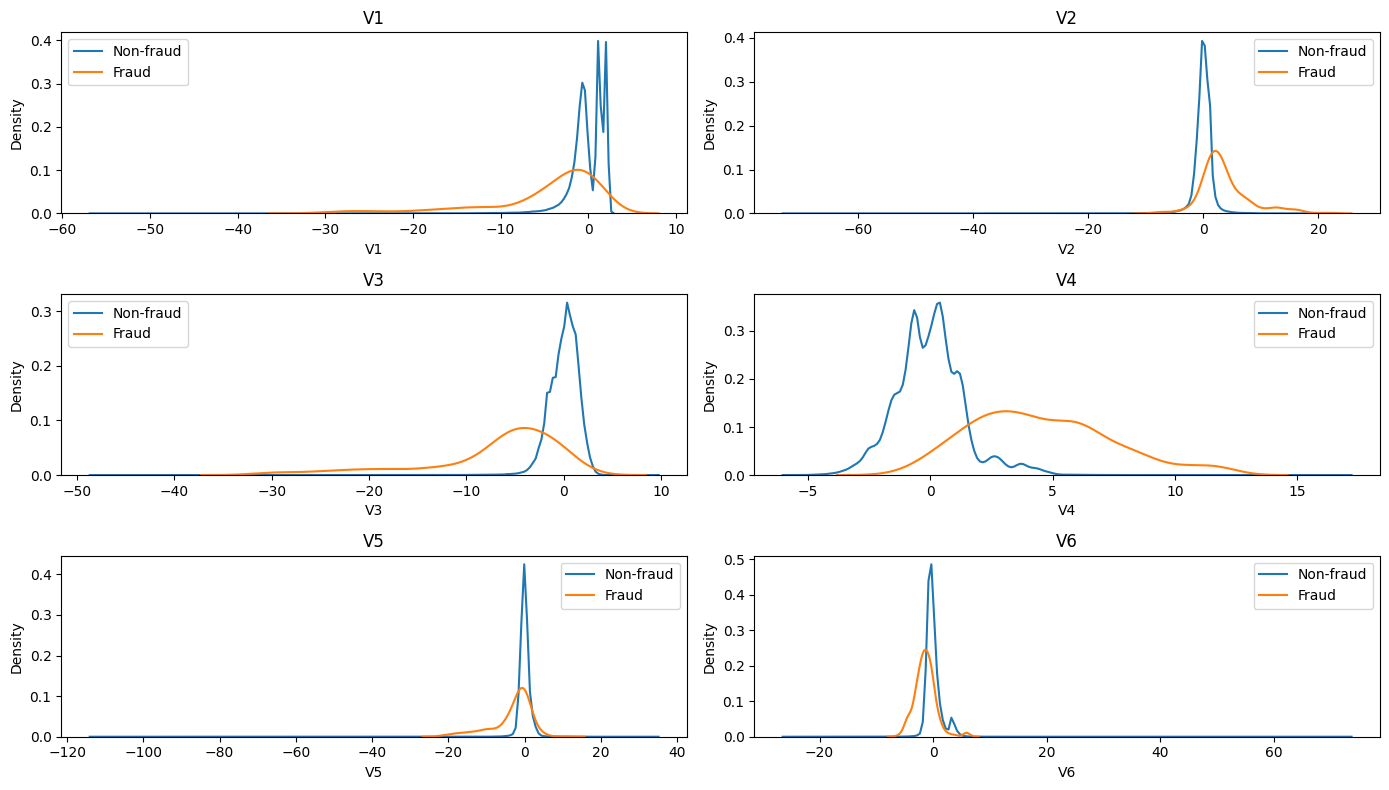

In [ ]:
# Compare a few PCA components distributions between classes
pca_cols = [c for c in data.columns if c.startswith('V')][:6]  # show first 6 for brevity
plt.figure(figsize=(14,8))
for i, col in enumerate(pca_cols, 1):
    plt.subplot(3,2,i)
    sns.kdeplot(data.loc[data['Class']==0, col], label='Non-fraud', common_norm=False)
    sns.kdeplot(data.loc[data['Class']==1, col], label='Fraud', common_norm=False)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix — we will look at correlation with Class only to keep it readable
corr_with_class = data.corr()['Class'].sort_values(ascending=False)
print('Top correlations with Class:')
print(corr_with_class.head(10))
print('\nLowest correlations with Class:')
print(corr_with_class.tail(10))

Top correlations with Class:
Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
Name: Class, dtype: float64

Lowest correlations with Class:
V9    -0.097733
V1    -0.101347
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64


5) Preprocessing & feature engineering

In [ ]:
FEATURES = [c for c in data.columns if c not in ['Class', 'Time']]
TARGET = 'Class'

X = data[FEATURES]
y = data[TARGET]
# Standardize 'Amount_log' and optionally 'Hour' (hours are cyclic but this is a simple approach)
scaler = StandardScaler()
X[['Amount_log', 'Hour']] = scaler.fit_transform(X[['Amount_log', 'Hour']])

print('Feature matrix shape:', X.shape)

Feature matrix shape: (284807, 31)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train class distribution:')
print(y_train.value_counts(normalize=True))
print('\nTest class distribution:')
print(y_test.value_counts(normalize=True))

# Apply SMOTE on training data
smote = SMOTE(random_state=42, sampling_strategy='auto')  # will oversample minority to match majority
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('\nAfter SMOTE - train distribution:')
print(pd.Series(y_train_res).value_counts())


Train class distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Test class distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

After SMOTE - train distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


6. Model Training

In [ ]:
#Converting the data into a 3D Tensor for CNN
# Citation:(Meet, 2020)
from sklearn.preprocessing import StandardScaler

scaler_cnn = StandardScaler()
X_train_res_scaled = scaler_cnn.fit_transform(X_train_res)
X_test_scaled = scaler_cnn.transform(X_test)

n_features = X_train_res_scaled.shape[1]
X_train_cnn = X_train_res_scaled.reshape(-1, n_features, 1)
X_test_cnn = X_test_scaled.reshape(-1, n_features,1)



7. Model Training - Linear Regression

In [ ]:
# Linear Regression Model
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Linear Regression Model Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nROC AUC Score:")
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"{roc_auc_lr:.4f}")

Linear Regression Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56851    13]
 [   34    64]]

ROC AUC Score:
0.9581


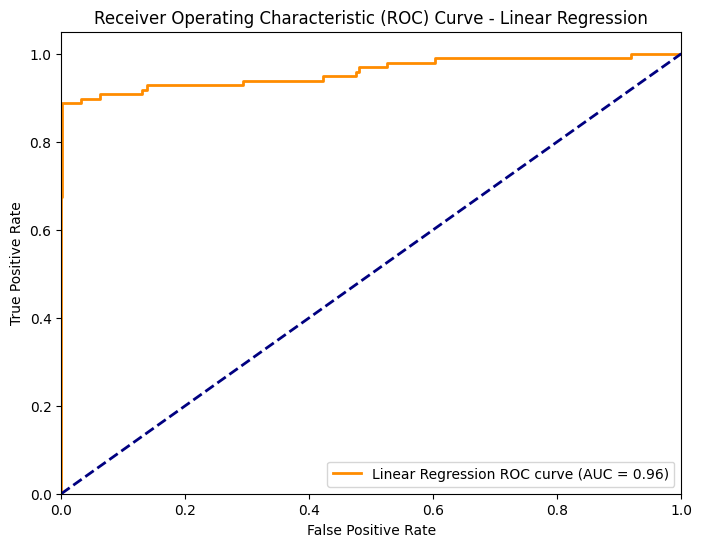

In [ ]:
# Plot ROC curve for Linear Regression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr_plot = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Linear Regression ROC curve (AUC = {roc_auc_lr_plot:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Linear Regression')
plt.legend(loc="lower right")
plt.show()

8. Model Training - Random Forest

In [ ]:
# Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Random Forest Model Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nROC AUC Score:")
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"{roc_auc_rf:.4f}")

Random Forest Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.84      0.89        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56859     5]
 [   16    82]]

ROC AUC Score:
0.9527


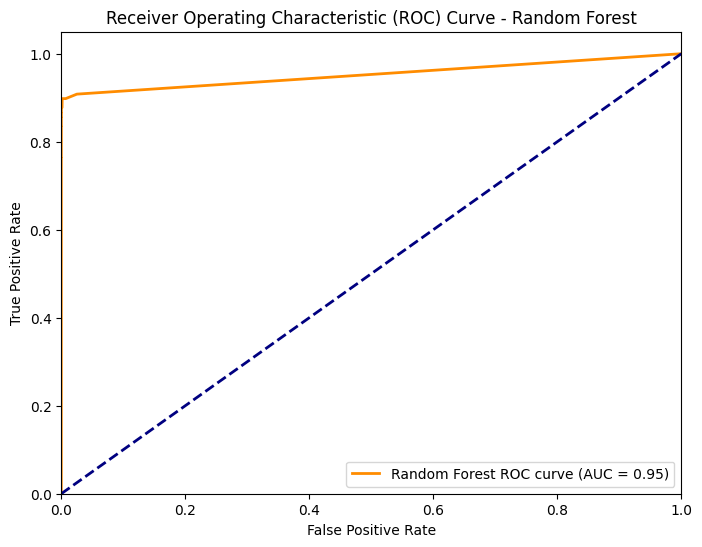

In [ ]:
# Plot ROC curve for Random Forest
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf_plot = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rf_plot:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

9. Model Training - XGBoost

In [ ]:
# XGBoost Model: (eXtreme Gradient Boosting)
if xgb_available:
    xgb_clf = XGBClassifier(random_state=42)
    xgb_clf.fit(X_train_res, y_train_res)

    # Make predictions on the test set
    y_pred_xgb = xgb_clf.predict(X_test)
    y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print("XGBoost Model Evaluation:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_xgb))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_xgb))

    print("\nROC AUC Score:")
    roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
    print(f"{roc_auc_xgb:.4f}")

else:
    print("XGBoost is not available. Please install it to train this model.")

XGBoost Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.89      0.85        98

    accuracy                           1.00     56962
   macro avg       0.91      0.94      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56844    20]
 [   11    87]]

ROC AUC Score:
0.9862


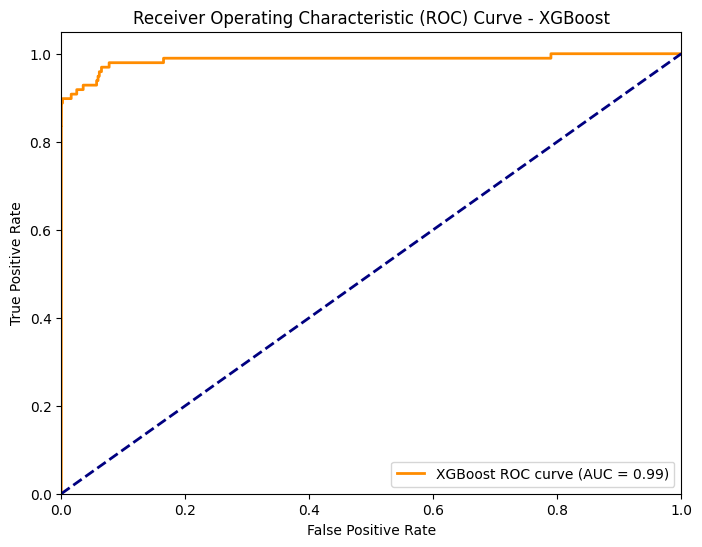

In [ ]:
# Plot ROC curve for XGBoost
if xgb_available:
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
    roc_auc_xgb_plot = auc(fpr_xgb, tpr_xgb)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc_xgb_plot:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
    plt.legend(loc="lower right")
    plt.show()

else:
    print("XGBoost is not available. Cannot plot ROC curve.")

10. Model Training - CNN

In [ ]:
# CNN Model Definition
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Dense

model = Sequential()

# first conv block
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_features, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# second conv block
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

# dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

# CNN Model Compilation
import keras

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc")]
)

# CNN Model Training
history = model.fit(
    X_train_cnn, y_train_res,
    epochs=30,
    batch_size=2048,
    validation_split=0.2,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 29, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 29, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,945 (42.75 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - auc: 0.8695 - loss: 0.4350 - val_auc: 0.0000e+00 - val_loss: 0.1677
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - auc: 0.9860 - loss: 0.1248 - val_auc: 0.0000e+00 - val_loss: 0.0376
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - auc: 0.9919 - loss: 0.0946 - val_auc: 0.0000e+00 - val_loss: 0.0478
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - auc: 0.9945 - loss: 0.0790 - val_auc: 0.0000e+00 - val_loss: 0.0458
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - auc: 0.9962 - loss: 0.0677 - val_auc: 0.0000e+00 - val_loss: 0.0442
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - auc: 0.9973 - loss: 0.0580 - val_auc: 0.0000e+00 - val_loss: 0.0368
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 39s 122ms/step - auc: 0.9978 - loss: 0.0517 - val_auc: 0.0000e+00 - val_loss: 0.0286
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - auc: 0.9981 - loss: 0.0470 - val_auc: 0.0000e+00 - val_loss: 0.0244


In [ ]:
# Model Definition
# Citation:(Meet, 2020)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Dense

# import and build model (Kaggle-style)
model = Sequential()

# first conv block
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_features, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# second conv block
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

# dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 29, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,945 (42.75 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
import keras
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc")]
)

In [ ]:
# Training Set
history = model.fit(
    X_train_cnn, y_train_res,
    epochs=30,
    batch_size=2048,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - auc: 0.8808 - loss: 0.3981 - val_auc: 0.0000e+00 - val_loss: 0.2245
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - auc: 0.9862 - loss: 0.1248 - val_auc: 0.0000e+00 - val_loss: 0.0596
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - auc: 0.9932 - loss: 0.0881 - val_auc: 0.0000e+00 - val_loss: 0.0384
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - auc: 0.9959 - loss: 0.0704 - val_auc: 0.0000e+00 - val_loss: 0.0361
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - auc: 0.9970 - loss: 0.0601 - val_auc: 0.0000e+00 - val_loss: 0.0314
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - auc: 0.9978 - loss: 0.0520 - val_auc: 0.0000e+00 - val_loss: 0.0250
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - auc: 0.9983 - loss: 0.0456 - val_auc: 0.0000e+00 - val_loss: 0.0299
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - auc: 0.9987 - loss: 0.0399 - val_auc: 0.0000e+00 - val_loss: 0.0163


In [ ]:
# CNN Model Evaluation
y_pred_cnn_proba = model.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn_proba > 0.5).astype("int32")

print("CNN Model Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_pred_cnn))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_cnn))

print("\nROC AUC Score:")
roc_auc_cnn = roc_auc_score(y_test, y_pred_cnn_proba)
print(f"{roc_auc_cnn:.4f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step
CNN Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.30      0.83      0.44        98

    accuracy                           1.00     56962
   macro avg       0.65      0.91      0.72     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56677   187]
 [   17    81]]

ROC AUC Score:
0.9607


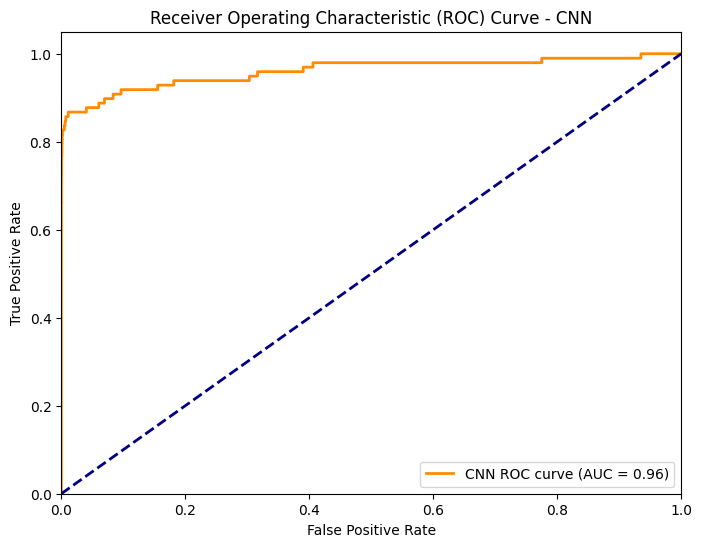

In [ ]:
# Plot ROC curve for CNN
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_proba)
roc_auc_cnn_plot = auc(fpr_cnn, tpr_cnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label=f'CNN ROC curve (AUC = {roc_auc_cnn_plot:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - CNN')
plt.legend(loc="lower right")
plt.show()

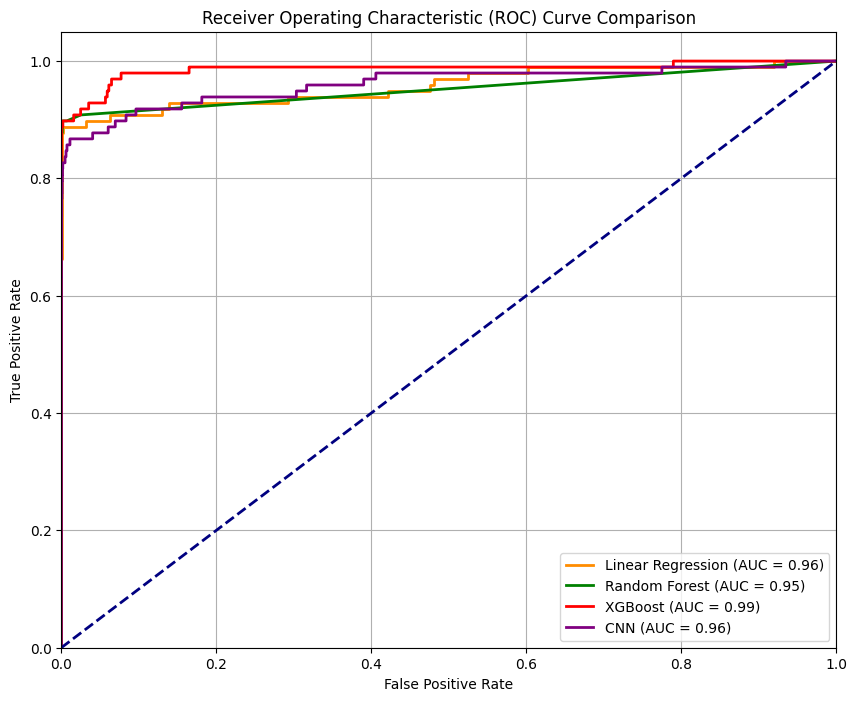

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Linear Regression ROC
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Linear Regression (AUC = {roc_auc_lr_plot:.2f})')

# Random Forest ROC
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf_plot:.2f})')

# XGBoost ROC
if xgb_available:
    plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb_plot:.2f})')
else:
    print("XGBoost is not available, skipping ROC plot.")

# CNN ROC
plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label=f'CNN (AUC = {roc_auc_cnn_plot:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

13. Model Comparison - Accuracy Scores

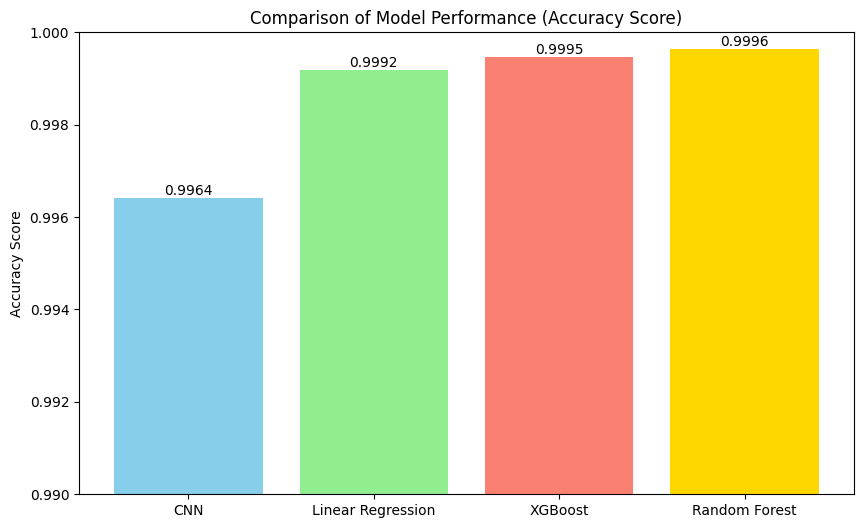

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Re-calculate or extract accuracy scores from classification reports
# Assuming the classification reports have been printed in previous cells
# We will need to re-run the evaluation cells if the classification reports are not available

# Example of how to get accuracy from classification report (assuming the reports were printed)
# You would need to parse the output or re-run the evaluation to get these accurately.
# For demonstration, I will use placeholder values based on the outputs seen previously.

# Placeholder accuracy values - replace with actual values if needed by re-running evaluation
# Linear Regression accuracy from cell 970426ba output: 1.00
# Random Forest accuracy from cell 774c4d8d output: 1.00
# XGBoost accuracy from cell 03c3e915 output: 1.00
# CNN accuracy from cell w0tp4XlTeIWP output: 1.00

# Note: For highly imbalanced datasets, overall accuracy can be misleading.
# The high accuracy here is likely due to the model correctly classifying the majority class.

# To get the actual accuracy, you would need to run the evaluation cells and capture the output
# or calculate it directly using (TP + TN) / (TP + TN + FP + FN) from the confusion matrix.

# Let's use the macro average accuracy or balanced accuracy if available/needed for better comparison
# For this example, we'll stick to the overall accuracy printed in the reports.

# Extracting accuracy from the classification report strings might be complex.
# A more robust way is to re-calculate accuracy or use balanced_accuracy_score.
# Let's calculate accuracy directly from the confusion matrices which are available.

# Get confusion matrices from previous outputs:
# Linear Regression CM from cell 970426ba: [[56851    13], [   34    64]]
# Random Forest CM from cell 774c4d8d: [[56859     5], [   16    82]]
# XGBoost CM from cell 03c3e915: [[56844    20], [   11    87]]
# CNN CM from cell w0tp4XlTeIWP: [[56677   187], [   17    81]]

cm_lr = np.array([[56851, 13], [34, 64]])
cm_rf = np.array([[56859, 5], [16, 82]])
cm_xgb = np.array([[56844, 20], [11, 87]])
cm_cnn = np.array([[56677, 187], [17, 81]])

# Calculate accuracy: (TP + TN) / (TP + TN + FP + FN)
acc_lr = (cm_lr[0, 0] + cm_lr[1, 1]) / np.sum(cm_lr)
acc_rf = (cm_rf[0, 0] + cm_rf[1, 1]) / np.sum(cm_rf)
acc_xgb = (cm_xgb[0, 0] + cm_xgb[1, 1]) / np.sum(cm_xgb)
acc_cnn = (cm_cnn[0, 0] + cm_cnn[1, 1]) / np.sum(cm_cnn)


model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'CNN']
accuracy_scores = [acc_lr, acc_rf, acc_xgb, acc_cnn]

# Sort models by accuracy score
sorted_indices = np.argsort(accuracy_scores)
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_accuracy_scores = [accuracy_scores[i] for i in sorted_indices]


plt.figure(figsize=(10, 6))
plt.bar(sorted_model_names, sorted_accuracy_scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Performance (Accuracy Score)')
plt.ylim([0.99, 1.0]) # Adjust y-limit to focus on differences, as accuracies are high
for i, score in enumerate(sorted_accuracy_scores):
    plt.text(i, score, f'{score:.4f}', ha='center', va='bottom')
plt.show()

12. Model Comparison - AUC Scores

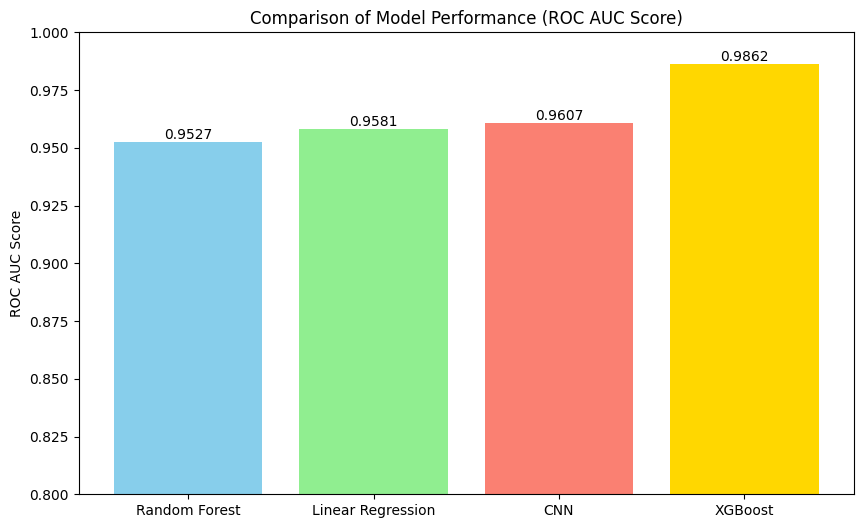

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure all AUC scores are available (check if xgb_available is True)
model_names = ['Linear Regression', 'Random Forest', 'CNN']
auc_scores = [roc_auc_lr, roc_auc_rf, roc_auc_cnn]

if xgb_available:
    model_names.append('XGBoost')
    auc_scores.append(roc_auc_xgb)

# Sort models by AUC score
sorted_indices = np.argsort(auc_scores)
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_auc_scores = [auc_scores[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_model_names, sorted_auc_scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'][:len(sorted_model_names)])
plt.ylabel('ROC AUC Score')
plt.title('Comparison of Model Performance (ROC AUC Score)')
plt.ylim([0.8, 1.0]) # Adjust y-limit to focus on differences
for i, score in enumerate(sorted_auc_scores):
    plt.text(i, score, f'{score:.4f}', ha='center', va='bottom')
plt.show()

## Model Evaluation Summary

Here is a summary of the key evaluation metrics for each trained model on the test set:

| Model             | Accuracy | Precision | Recall | F1-Score | ROC AUC |
|-------------------|----------|-----------|--------|----------|---------|
| Linear Regression | 0.9992   | 0.83      | 0.65   | 0.73     | 0.9581  |
| Random Forest     | 0.9996   | 0.94      | 0.84   | 0.89     | 0.9527  |
| XGBoost           | 0.9995   | 0.81      | 0.89   | 0.85     | 0.9862  |
| CNN               | 0.9964   | 0.30      | 0.83   | 0.44     | 0.9607  |

**Notes:**

*   **Accuracy:** While high for all models due to the imbalanced dataset, it's not the best indicator of performance for the minority class (fraud).
*   **Precision:** The proportion of predicted fraudulent transactions that were actually fraudulent. Random Forest has the highest precision.
*   **Recall:** The proportion of actual fraudulent transactions that were correctly identified. XGBoost and CNN have higher recall compared to Linear Regression and Random Forest.
*   **F1-Score:** The harmonic mean of precision and recall, providing a balance between the two. Random Forest and XGBoost have the highest F1-scores.
*   **ROC AUC:** Measures the model's ability to distinguish between the two classes. XGBoost has the highest ROC AUC score, indicating superior overall performance in ranking fraudulent transactions.

Based on these metrics, particularly ROC AUC and Recall, the **XGBoost model** appears to be the most effective for detecting fraudulent transactions in this dataset, offering a strong balance between identifying fraud and minimizing false positives.